Acknowledge that the dataset herein is miniature and can be toyed with on Jupyter nb using a local machine, perhaps with single GPU. More realistic datasets would require API interfacing with a cluster and data engineering pipelines to display distributions of billions of params over time, or to run robust imputation methods for missing data as standalone endeavors before one even considers modeling.


In [1789]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(42)

In [1790]:
data = pd.read_csv("../data/train_sparked.csv")
X_test_nulls_raw = pd.read_csv("../data/test_sparked.csv")

In [1791]:
data

,SellerIsPriv,SellerListSrc,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,VehColorInt,VehDriveTrain,...,VehMileage,VehModel,VehPriceLabel,VehYear,Vehicle_Trim,Dealer_Listing_Price,NumOwners,Word2Vec_VehSellerNotes,Word2Vec_SellerCity,Word2Vec_SellerName
0,False,inventorycommandcenter,5.0,32,MI,48091,False,white,black,4wd,...,39319,grandcherokee,fairprice,2015,High Altitude,30990.0,1.0,"[-0.053365785628557205,-0.37472790479660034,-0...","[-0.0016291951760649681,0.003000099677592516,-...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
1,False,cadillaccertifiedprogram,4.8,1456,ND,58103,True,black,NaN,NaN,...,30352,xt5,gooddeal,2017,NaN,34860.0,1.0,"[0.1272071421146393,-0.30182115957140926,-0.17...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
2,False,jeepcertifiedprogram,4.8,1405,WI,53186,True,brilliantblackcrystalpearlcoat,black,4wd,...,38957,grandcherokee,gooddeal,2015,Laredo,23249.0,1.0,"[-0.030570422842477758,-0.21255869658764553,-0...","[-0.008836379274725914,0.00765074510127306,0.0...","[-0.0003782296262215823,0.017246218398213387,0..."
3,False,inventorycommandcenter,4.4,21,MO,63385,False,diamondblackcrystalpearlcoat,black,4wd,...,20404,grandcherokee,gooddeal,2018,Limited,31977.0,1.0,"[0.012842207112246089,-0.2895167774210373,-0.1...","[0.011451316066086292,0.0008524131844751537,0....","[0.014063520357012749,-0.010786726139485836,-0..."
4,False,homenetautomotive,3.7,74,AR,72703,False,radiantsilvermetallic,cirrus,fwd,...,19788,xt5,gooddeal,2018,Luxury,33495.0,1.0,"[0.08765041478126928,-0.21045361228381135,-0.0...","[-0.0062690903432667255,0.012396407313644886,-...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6289,True,sellityourself,0.0,0,MI,48126,False,black,black,4wd,...,49000,grandcherokee,NaN,2015,High Altitude,18699.0,NaN,"[0.08423407225100991,-0.08781853420753974,-0.0...","[-0.009339320473372936,-0.015448863618075848,-...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
6290,False,digitalmotorworksdmi,3.3,16,IN,46280,False,gray,black,4wd,...,20039,grandcherokee,fairprice,2015,Limited,31998.0,1.0,"[0.09979269340997964,-0.3885182706110271,-0.17...","[0.005609495565295219,0.001513063907623291,0.0...","[-0.01396772637963295,-0.019747698679566383,-0..."
6291,False,digitalmotorworksdmi,4.1,20,OH,43017,True,black,jetblack,fwd,...,16278,xt5,gooddeal,2018,Luxury,35674.0,0.0,"[0.07624887947545007,-0.19738102471455932,-0.0...","[-0.014656727202236652,0.013546908274292946,0....","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."
6292,False,digitalmotorworksdmi,4.9,278,OH,44870,False,black,jetblack,fwd,...,38146,xt5,greatdeal,2017,Luxury,31995.0,2.0,"[0.009715850736258677,-0.18269026498717156,-0....","[-0.019043318927288055,0.006895005702972412,-0...","[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0..."


In [1792]:
data.dtypes

SellerIsPriv                  bool
SellerListSrc               object
SellerRating               float64
SellerRevCnt                 int64
SellerState                 object
SellerZip                    int64
VehCertified                  bool
VehColorExt                 object
VehColorInt                 object
VehDriveTrain               object
VehEngine                   object
VehFeats                    object
VehFuel                     object
VehHistory                  object
VehListdays                float64
VehMake                     object
VehMileage                   int64
VehModel                    object
VehPriceLabel               object
VehYear                      int64
Vehicle_Trim                object
Dealer_Listing_Price       float64
NumOwners                  float64
Word2Vec_VehSellerNotes     object
Word2Vec_SellerCity         object
Word2Vec_SellerName         object
dtype: object

In [1793]:
len(data["Word2Vec_VehSellerNotes"].unique()), len(data["Word2Vec_SellerName"].unique())

(4873, 580)

In [1794]:
from ast import literal_eval

# unfortunatley get this hiccup going from pyspark to pandas without parquet or other tools to assist; numeric vecs will be read in as list of str and cause all sort of mayhem
# for the sake of time, will take L2 norm as a feature replacement.
corruptedNum = [
    "Word2Vec_VehSellerNotes",
    "Word2Vec_SellerCity",
    "Word2Vec_SellerName",
]


def sss(x):
    return np.sqrt(sum(val**2 for val in x))


for c in corruptedNum:
    data[c] = data[c].apply(literal_eval)
    data[c] = data[c].apply(list)
    X_test_nulls_raw[c] = X_test_nulls_raw[c].apply(literal_eval)
    X_test_nulls_raw[c] = X_test_nulls_raw[c].apply(list)
    # data[c] = data[c].apply(sss)
    # X_test_nulls_raw[c] = X_test_nulls_raw[c].apply(sss)


# We also will have to record null rows here as np functions will spazz out with these types
X_train_null_id = data[data.isnull().any(axis=1)].index
X_test_null_id = X_test_nulls_raw[data.isnull().any(axis=1)].index

C:\Users\gbert\AppData\Local\Temp\ipykernel_14856\262549547.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_null_id = X_test_nulls_raw[data.isnull().any(axis=1)].index


In [1795]:
data.dtypes

SellerIsPriv                  bool
SellerListSrc               object
SellerRating               float64
SellerRevCnt                 int64
SellerState                 object
SellerZip                    int64
VehCertified                  bool
VehColorExt                 object
VehColorInt                 object
VehDriveTrain               object
VehEngine                   object
VehFeats                    object
VehFuel                     object
VehHistory                  object
VehListdays                float64
VehMake                     object
VehMileage                   int64
VehModel                    object
VehPriceLabel               object
VehYear                      int64
Vehicle_Trim                object
Dealer_Listing_Price       float64
NumOwners                  float64
Word2Vec_VehSellerNotes     object
Word2Vec_SellerCity         object
Word2Vec_SellerName         object
dtype: object

In [1796]:
X_test_nulls_raw

,ListingID,SellerIsPriv,SellerListSrc,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,VehColorInt,...,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehYear,NumOwners,Word2Vec_VehSellerNotes,Word2Vec_SellerCity,Word2Vec_SellerName
0,8622015,False,homenetautomotive,2.5,59,SC,29678,False,stellarblackmetallic,cirrus,...,143.991262,Cadillac,13625.0,xt5,gooddeal,2018,1.0,"[-0.008756550476031768, -0.21442532301419875, ...","[-0.01729607582092285, -0.018898246809840202, ...","[-0.013677525334060192, 0.0031936836894601583,..."
1,8625693,False,inventorycommandcenter,4.7,2116,OH,44146,False,truebluepearlcoat,black,...,138.770486,Jeep,42553.0,grandcherokee,gooddeal,2017,1.0,"[0.03471486289386771, -0.10017236127917256, -0...","[0.014633934944868088, 0.004559137858450413, -...","[0.017363380640745163, 0.010169243440032005, -..."
2,8625750,False,jeepcertifiedprogram,3.9,46,NY,14580,True,brilliantblackcrystalpearlcoat,black,...,31.951088,Jeep,48951.0,grandcherokee,gooddeal,2015,1.0,"[-0.020958804962235972, -0.09792552503285185, ...","[-0.00936238095164299, -0.008331635035574436, ...","[-0.014656727202236652, 0.013546908274292946, ..."
3,8626885,False,digitalmotorworksdmi,4.5,1075,KY,40222,False,brilliantblackcrystalpearlcoat,black,...,5.950127,Jeep,44179.0,grandcherokee,gooddeal,2015,1.0,"[-0.0007742528926222551, 0.0002273344881977056...","[0.011585481464862823, 0.005907111335545778, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,8627430,False,digitalmotorworksdmi,4.6,162,NJ,8065,False,harborbluemetallic,jetblack,...,24.672986,Cadillac,22269.0,xt5,gooddeal,2018,1.0,"[-0.017189942575730238, -0.14738842444349415, ...","[-0.011382665485143661, 0.007269668392837048, ...","[0.005609495565295219, 0.001513063907623291, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9992442,False,homenetautomotive,4.8,1081,IL,60130,False,granitecrystalmetallicclearcoat,black,...,18.091597,Jeep,24744.0,grandcherokee,gooddeal,2017,1.0,"[0.05133242817019267, -0.04046664651767288, 0....","[-0.0003782296262215823, 0.017246218398213387,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
996,9993562,False,inventorycommandcenter,4.0,240,FL,33614,False,black,jetblack,...,167.799676,Cadillac,5699.0,xt5,gooddeal,2017,1.0,"[0.011138781652365558, -0.1769546296008985, -0...","[-0.01583714783191681, 0.015620743855834007, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
997,9994646,False,homenetautomotive,5.0,134,FL,33612,False,radiantsilvermetallic,jetblack,...,46.215625,Cadillac,17985.0,xt5,gooddeal,2018,1.0,"[0.07603358410632433, -0.048736872218678985, -...","[-0.01583714783191681, 0.015620743855834007, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
998,9997199,False,inventorycommandcenter,3.8,7,NY,14075,False,diamondblack,black,...,14.907535,Jeep,27.0,grandcherokee,fairprice,2018,1.0,"[-0.008404785767197609, -0.13934041857719423, ...","[0.017957499250769615, -0.0029464627150446177,...","[-0.01724843680858612, 0.01980431005358696, 0...."


In [1797]:
y_train_nulls = data[["Dealer_Listing_Price", "Vehicle_Trim"]]
y_train_null_id = y_train_nulls[data.isnull().any(axis=1)].index


X_train_nulls_raw = data.drop(
    ["Dealer_Listing_Price", "Vehicle_Trim"], axis=1
)  # nulls to indicate nulls present and raw to indicate ft are not numerically encoded yet
y_test_id_nulls_raw = X_test_nulls_raw["ListingID"]  # save for later
X_test_nulls_raw = X_test_nulls_raw.drop(["ListingID"], axis=1)

We note some features that only have two options and are binarized. Recall that OrdinalEncoder is suitable for categorical variables with a meaningful order. OneHotEncoder is suitable for categorical variables without a natural specific order and can be used to binarize. Seller rating is tricky to deal with as it's a numeric categorical feature as ratings are still an ordinal measure (what does 3.5 rating - 2.0 vs 1.0 + 5.0 rating even mean??) Before we tend to these pipelines simplify the codification of ext/int colors as there is a lot of repetition.


In [1798]:
# Words to match and replace with the corresponding color name
colors_to_replace = [
    "blue",
    "red",
    "black",
    "silver",
    "white",
    "cashmere",
    "steel",
    "granite",
    "ivory",
    "amethyst",
    "green",
    "gray",
    "brown",
    "bronze",
    "auburn",
    "sangria",
    "mocha",
    "rhino",
]

# Constructing a regular expression pattern to match any portion containing the specified colors
pattern = "|".join(colors_to_replace)

# Replace any portion of the string containing 'blue', 'red', or 'black' etc with only the corresponding color name
# The r'\1' in the value parameter is a backreference to the matched portion, so it replaces the entire string with only the color name.
X_train_nulls_raw["VehColorExt"] = X_train_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorExt"] = X_test_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorExt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorExt"].unique()),
)

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 48
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 31


In [1799]:
X_train_nulls_raw["VehColorInt"] = X_train_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorInt"] = X_test_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorInt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorInt"].unique()),
)

# Careful not to overreach and drop colors you do not see in the test set as it's meant to be beyond our purview. This was simply to cut down on complexity

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 38
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 22


We also want to make zip codes like 12345 to [1,2,3,4,5] vectors


In [1800]:
X_train_nulls_raw.columns, X_train_nulls_raw.shape, X_test_nulls_raw.shape

(Index(['SellerIsPriv', 'SellerListSrc', 'SellerRating', 'SellerRevCnt',
        'SellerState', 'SellerZip', 'VehCertified', 'VehColorExt',
        'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
        'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
        'VehPriceLabel', 'VehYear', 'NumOwners', 'Word2Vec_VehSellerNotes',
        'Word2Vec_SellerCity', 'Word2Vec_SellerName'],
       dtype='object'),
 (6294, 24),
 (1000, 24))

Since we just are encoding here there is no danger in leakage (not true if adding ML model predictions as another step)


In [1801]:
X_nulls = pd.concat([X_train_nulls_raw, X_test_nulls_raw])
X_nulls.shape

(7294, 24)

In [1802]:
X_nulls.columns, len(X_nulls.columns)

(Index(['SellerIsPriv', 'SellerListSrc', 'SellerRating', 'SellerRevCnt',
        'SellerState', 'SellerZip', 'VehCertified', 'VehColorExt',
        'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats', 'VehFuel',
        'VehHistory', 'VehListdays', 'VehMake', 'VehMileage', 'VehModel',
        'VehPriceLabel', 'VehYear', 'NumOwners', 'Word2Vec_VehSellerNotes',
        'Word2Vec_SellerCity', 'Word2Vec_SellerName'],
       dtype='object'),
 24)

In [1803]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Define column subsets
categorical_cols = [
    "SellerIsPriv",
    "SellerListSrc",
    "SellerState",
    "SellerZip",
    "VehCertified",
    "VehColorExt",
    "VehColorInt",
    "VehDriveTrain",
    "VehEngine",
    "VehFeats",
    "VehFuel",
    "VehHistory",
    "VehMake",
    "VehModel",
]
ordinal_cols = ["SellerRating", "VehPriceLabel"]
numeric_cols = ["SellerRevCnt", "VehListdays", "VehMileage", "VehYear", "NumOwners"]

# Create transformers
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
        ),
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True)),
    ]  # https://stackoverflow.com/questions/52008548/python-running-into-x-test-y-test-fit-errors
)

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("ord", ordinal_transformer, ordinal_cols),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="passthrough",  # NOTE CRITICAL -- leave the other features not explicitly called as is but make sure all cols accounted for
)

# Create a final pipeline with the preprocessor and any subsequent steps (e.g., a model)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Add additional steps as needed, e.g., a machine learning model -- holding off as we want to do imputation study
    ]
)
X = final_pipeline.fit_transform(X_nulls)

In [1804]:
X.shape

(7294, 3207)

In [1805]:
X_train_nulls = X[: len(X_train_nulls_raw)]  # drop raw as now encoded
X_test_nulls = X[len(X_train_nulls_raw) :]
X_train_nulls.shape, X_test_nulls.shape

((6294, 3207), (1000, 3207))

In [1806]:
pd.DataFrame(X_train_nulls)

,0,1,2,3,4,5,6,7,8,9,...,3197,3198,3199,3200,3201,3202,3203,3204,3205,3206
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,39.0,0.0,-0.313098,-0.701742,1.00546,-1.483348,-0.0574,"[-0.053365785628557205, -0.37472790479660034, ...","[-0.0016291951760649681, 0.003000099677592516,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,1.0,0.774006,-0.78622,0.314432,0.172155,-0.0574,"[0.1272071421146393, -0.30182115957140926, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37.0,1.0,0.735072,-0.411614,0.977563,-1.483348,-0.0574,"[-0.030570422842477758, -0.21255869658764553, ...","[-0.008836379274725914, 0.00765074510127306, 0...","[-0.0003782296262215823, 0.017246218398213387,..."
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,33.0,1.0,-0.321496,0.060008,-0.452196,0.999906,-0.0574,"[0.012842207112246089, -0.2895167774210373, -0...","[0.011451316066086292, 0.0008524131844751537, ...","[0.014063520357012749, -0.010786726139485836, ..."
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,26.0,1.0,-0.281035,0.637803,-0.499667,0.999906,-0.0574,"[0.08765041478126928, -0.21045361228381135, -0...","[-0.0062690903432667255, 0.012396407313644886,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6289,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,-0.337527,-0.386702,1.751511,-1.483348,NaN,"[0.08423407225100991, -0.08781853420753974, -0...","[-0.009339320473372936, -0.015448863618075848,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6290,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,0.0,-0.325313,-0.757664,-0.480324,-1.483348,-0.0574,"[0.09979269340997964, -0.3885182706110271, -0....","[0.005609495565295219, 0.001513063907623291, 0...","[-0.01396772637963295, -0.019747698679566383, ..."
6291,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,1.0,-0.322259,1.920703,-0.770159,0.999906,-2.817264,"[0.07624887947545007, -0.19738102471455932, -0...","[-0.014656727202236652, 0.013546908274292946, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6292,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,2.0,-0.125298,0.268998,0.915064,0.172155,2.702465,"[0.009715850736258677, -0.18269026498717156, -...","[-0.019043318927288055, 0.006895005702972412, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Now that we have encoded the data let's take a look at the distributions (without the compression from encoding)


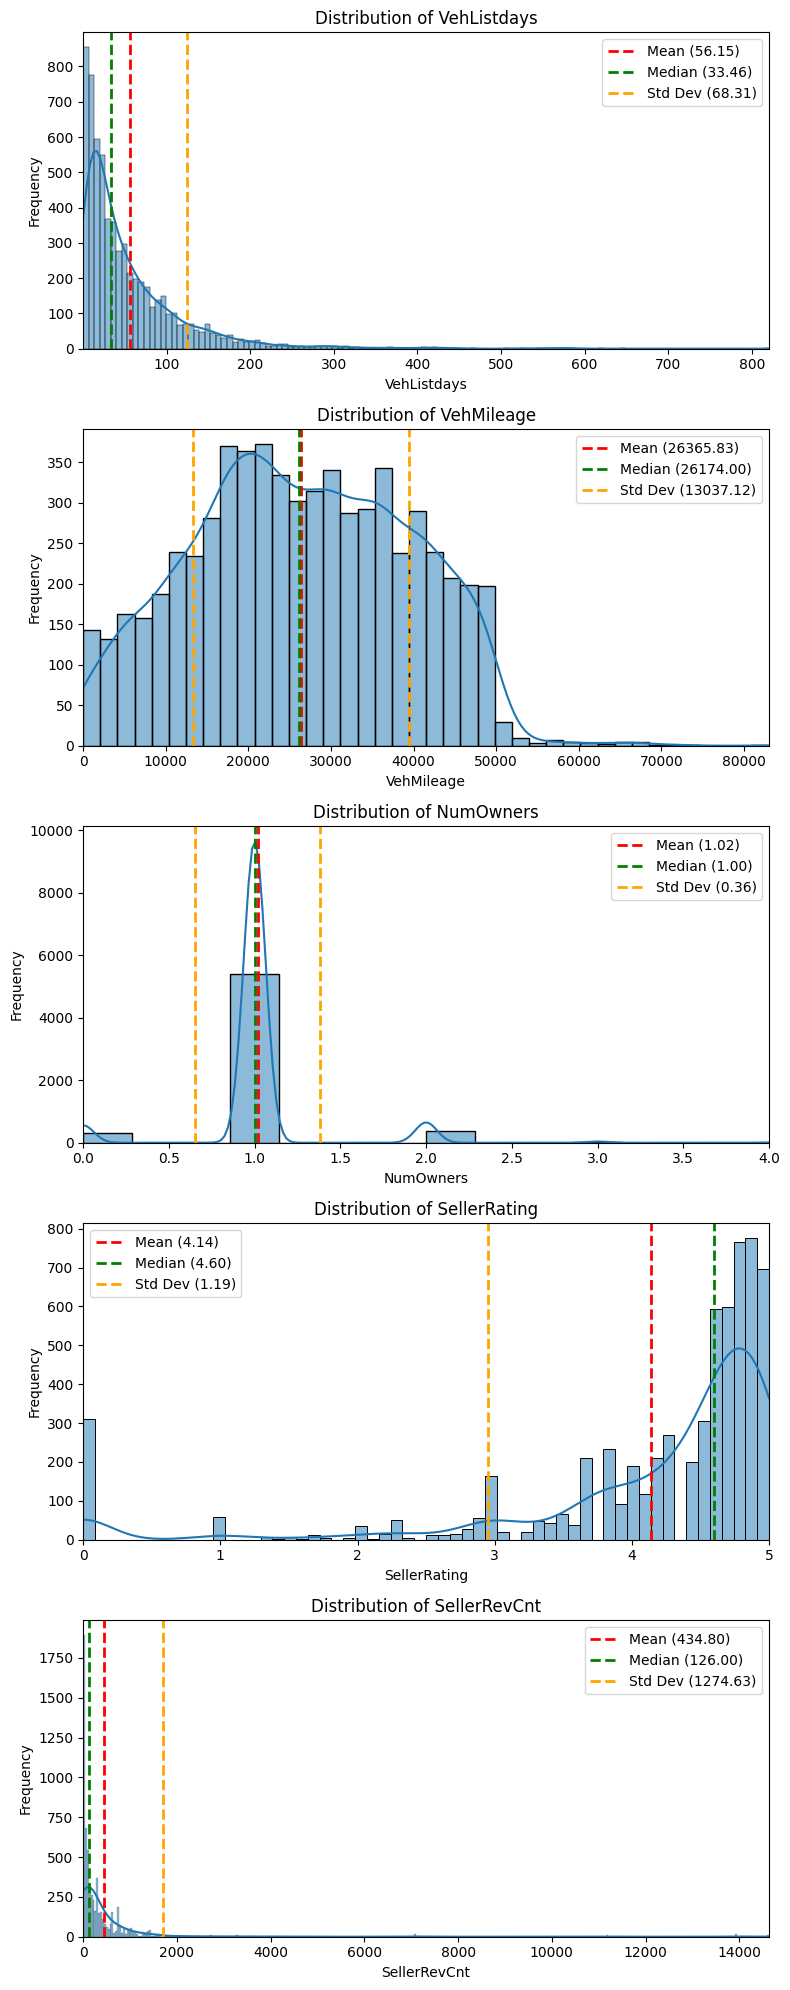

In [1807]:
import seaborn as sns
import matplotlib.pyplot as plt

distCol = [
    "VehListdays",
    "VehMileage",
    "NumOwners",
    "SellerRating",
    "SellerRevCnt",
]
# Set up subplots -- NOTE: Dealer_Listing_Price is part of what we want to predict!
fig, axes = plt.subplots(nrows=len(distCol), ncols=1, figsize=(8, 4 * len(distCol)))

## Plot distribution and statistics for each column
for i, column in enumerate(distCol):
    # Plot distribution
    sns.histplot(X_train_nulls_raw[column], kde=True, ax=axes[i])

    # Calculate statistics
    mean_value = X_train_nulls_raw[column].mean()
    median_value = X_train_nulls_raw[column].median()
    std_dev_value = X_train_nulls_raw[column].std()

    # Plot major statistics below the distribution plot
    axes[i].axvline(
        mean_value,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean ({mean_value:.2f})",
    )
    axes[i].axvline(
        median_value,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Median ({median_value:.2f})",
    )
    axes[i].axvline(
        mean_value + std_dev_value,
        color="orange",
        linestyle="dashed",
        linewidth=2,
        label=f"Std Dev ({std_dev_value:.2f})",
    )
    axes[i].axvline(
        mean_value - std_dev_value, color="orange", linestyle="dashed", linewidth=2
    )
    axes[i].legend()

    # Set x-axis limits to the minimum and maximum values of the distribution
    axes[i].set_xlim(X_train_nulls_raw[column].min(), X_train_nulls_raw[column].max())

    # Set plot labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Distribution of {column}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

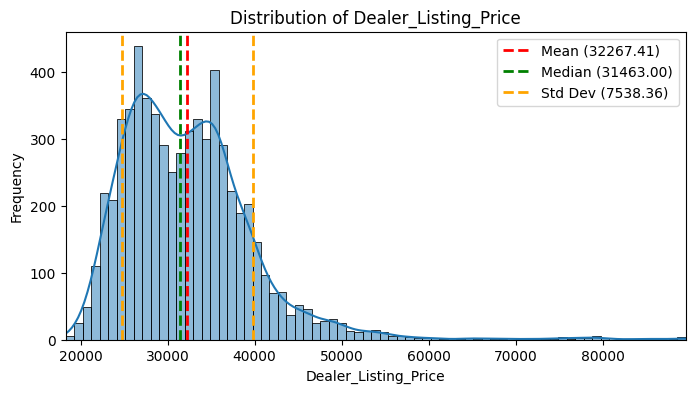

In [1808]:
# Set up subplots
fig, ax = plt.subplots(figsize=(8, 4))

# Plot distribution
sns.histplot(y_train_nulls["Dealer_Listing_Price"], kde=True, ax=ax)

# Calculate statistics
mean_value = y_train_nulls["Dealer_Listing_Price"].mean()
median_value = y_train_nulls["Dealer_Listing_Price"].median()
std_dev_value = y_train_nulls["Dealer_Listing_Price"].std()

# Plot major statistics below the distribution plot
ax.axvline(
    mean_value,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value:.2f})",
)
ax.axvline(
    median_value,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value:.2f})",
)
ax.axvline(
    mean_value + std_dev_value,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value:.2f})",
)
ax.axvline(mean_value - std_dev_value, color="orange", linestyle="dashed", linewidth=2)
ax.legend()

# Set x-axis limits to the minimum and maximum values of the distribution
ax.set_xlim(
    y_train_nulls["Dealer_Listing_Price"].min(),
    y_train_nulls["Dealer_Listing_Price"].max(),
)

# Set plot labels and title
ax.set_xlabel("Dealer_Listing_Price")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Dealer_Listing_Price")

# Show the plot
plt.show()

None of the data distributions look Gaussian but standard scaling will be used as it will not change the shape of the distribution.

https://stats.stackexchange.com/questions/453211/using-standardscaler-function-of-scikit-learn-library
https://stats.stackexchange.com/questions/290958/logistic-regression-and-scaling-of-features


At this point it is time to impute missing data before we drop certain rows due to outliers, say, outside 3 std dev from in-column averages. We shall use a random forest model (less sensitive to outliers present) as a baseline model for imputation though other NN-backed methods can be explored and explore various imputers.

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py


First want to get a score on a dataset which had no missing values


Let's start by getting the data into numerical input schemes for missing data (nulls). To do this and avoid data leakage, we need the statistics calculated for each column are calculated on the training dataset only, then applied to the train and test sets for each fold in the dataset under consideration. For the sake of time we will use a Random Forest regressor as the baseline imputation model. Other approaches can develop a NN-backed approach instead or use other ensemble methods.

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
